### `Load Data and Libraries`

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd

# import Tokenizer and pad_sequences
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

dataset = pd.read_csv('/Users/avaneeshkumar/Downloads/NLP_Case_Study/Data.csv', parse_dates=["tweet_created"])

In [24]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stop = set(stopwords.words('english'))
from textblob import Word
import tensorflow_hub as hub

###  `Cleaning and preparing data`

In [4]:
# Average Word Length
def avg_word(sentence):
        words = sentence.split()
        if len(words) == 0:
            pass
        else:
            return (sum(len(word) for word in words)/len(words))
    
    
# basic preprocessing steps
def text_processing(data):

    # Number of Words
    data['word_count'] = data['text'].apply(lambda x: len(str(x).split(" ")))

    # Number of characters
    data['char_count'] = data['text'].str.len()
    
    # average word count for each word
    data['avg_word'] = data['text'].apply(lambda x: avg_word(x))

    # Number of stopwords
    data['stopwords'] = data['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
    
    # Number of mentions or hastags
    data['hastags'] = data['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
    
    # Number of numerics
    data['numerics'] = data['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    
    # Number of uppercase words
    data['upper'] = data['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    
    # Preprocessing test
    data['text'] = data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove twitter handlers 
    data['text'] = data['text'].str.replace('@[^\s]+', " ")
    
    # removing special characters
    data['text'] = data['text'].str.replace("[^a-zA-Z#]", " ")
    
    # Removing Punctuation
    data['text'] = data['text'].str.replace('[^\w\s]',' ')
    
    # Removing stopwords
    data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    # Common word removal
    freq = pd.Series(' '.join(data['text']).split()).value_counts()[:25]

    freq_ind = list(freq.index)
    data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_ind))

    # spelling correct removal
    # tweeet_data['text'].apply(lambda x: str(TextBlob(x).correct()))
    
    # small words
    data['text'] = data['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

    # Lemmatization
    data['text'] = data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    # label encoding the output
    le = preprocessing.LabelEncoder()
    data['label'] = le.fit_transform(data.sentiment.values)
    
    return data

In [5]:
dataset = text_processing(dataset)

In [6]:
# partioning data into train and sample
train_data = dataset.iloc[:14000]

sample_data = dataset.iloc[14000:]

### `Preprocessing the data (array conversion)`

In [7]:
# converting to list
sentences = train_data['text'].tolist()
labels = train_data['label'].tolist()
sample_seq = sample_data["text"].tolist()
sample_label = sample_data["label"].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)
sample_labels_final = np.array(sample_label)


#### Tokenize and padding of the sequence  (Build vocabulary)

In [8]:
vocab_size = 3000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Tokeniser using oov for out of vector word marking
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# fitting the model
tokenizer.fit_on_texts(training_sentences)

# map the work embeddings
word_index = tokenizer.word_index

# generate sequence from sentences and padding the sequence 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

# testing the sequences & padding 
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

# sample sequence and padding 
sample_sequences = tokenizer.texts_to_sequences(sample_seq)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)
    


### `MODEL BUILDING`

#### Baseline model

In [9]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model.summary()

num_epochs = 3
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           48000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 21        
Total params: 48,123
Trainable params: 48,123
Non-trainable params: 0
_________________________________________________________________


#### Visualizing embeddings without training

In [10]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

# Create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')
    

(3000, 16)


#### Please copy paste the below url in your browser to visualise the embeddings
https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/Kumaava/724ac2ee5781e994564cb0e64d82c897/raw/a05434d5184024bbca39c56354666fca46367604/config.json

### `Training model (Baseline)`

* Training a simple sequencial model for sentiment analysis

In [11]:
num_epochs = 50
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 11200 samples, validate on 2800 samples
Epoch 1/50
11200/11200 [==============================] - 4s 361us/sample - loss: 0.9892 - accuracy: 0.5982 - val_loss: 0.8399 - val_accuracy: 0.7068
Epoch 2/50
11200/11200 [==============================] - 3s 228us/sample - loss: 0.9465 - accuracy: 0.5982 - val_loss: 0.8338 - val_accuracy: 0.7068
Epoch 3/50
11200/11200 [==============================] - 3s 223us/sample - loss: 0.9419 - accuracy: 0.5982 - val_loss: 0.8279 - val_accuracy: 0.7068
Epoch 4/50
11200/11200 [==============================] - 2s 217us/sample - loss: 0.9346 - accuracy: 0.5982 - val_loss: 0.8209 - val_accuracy: 0.7068
Epoch 5/50
11200/11200 [==============================] - 2s 217us/sample - loss: 0.9195 - accuracy: 0.5982 - val_loss: 0.7919 - val_accuracy: 0.7068
Epoch 6/50
11200/11200 [==============================] - 2s 221us/sample - loss: 0.8835 - accuracy: 0.5982 - val_loss: 0.7610 - val_accuracy: 0.7068
Epoch 7/50
11200/11200 [===========================

#### Visualizing embeddings post training

In [12]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

# Create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Write out the embedding vectors and metadata
out_v = io.open('vecs_trained.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_trained.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs_trained.tsv')
    files.download('meta_trained.tsv')
    

(3000, 16)


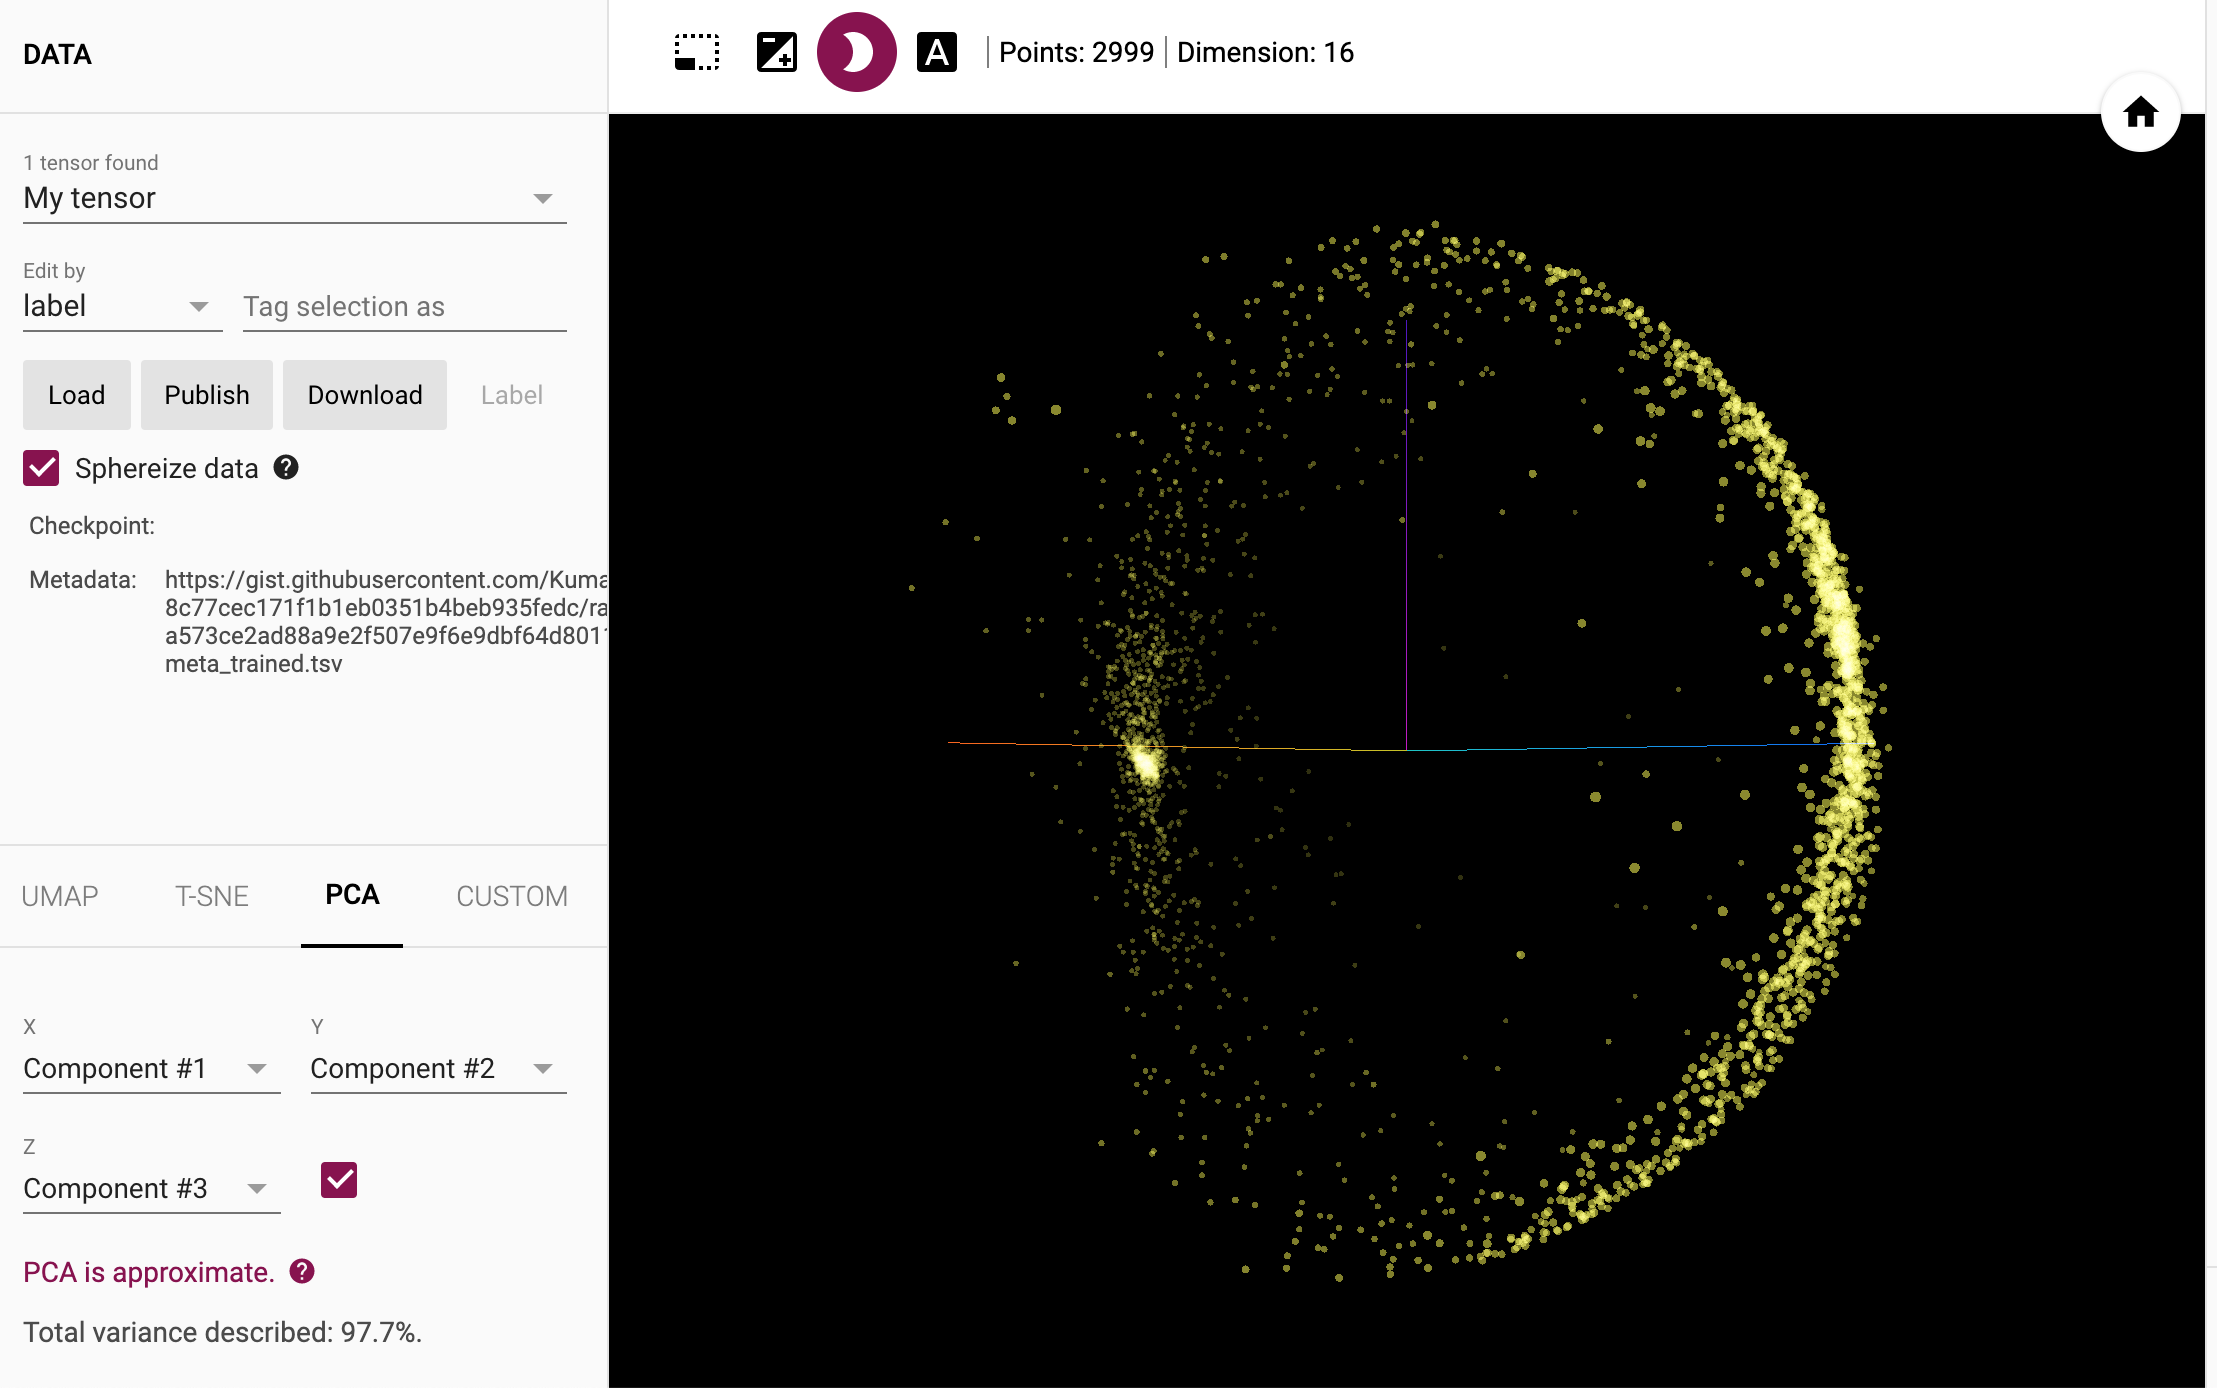

In [13]:
from IPython.display import Image
Image(filename='/Users/avaneeshkumar/Desktop/Trained_embeddings.png',width=800, height=400)

#### Please click on the URL and click "sphereize data" on the webpage. 

https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/Kumaava/8c77cec171f1b1eb0351b4beb935fedc/raw/51ff2d135fed6b8abab0693c5e8d86629f4f29f9/trained_embedding.json


#### Plotting loss

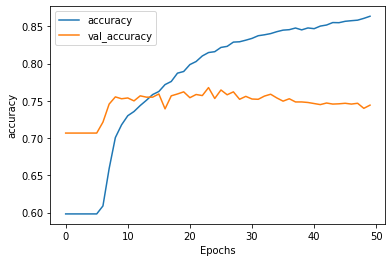

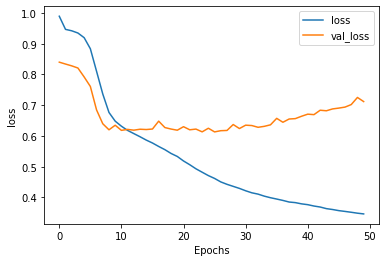

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Creating featres and potting training progress

In [19]:
def fit_model_now (model, num_epochs, sentences):
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    
    model.summary()
    
    history  = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                         validation_data=(testing_padded, testing_labels_final))

    return history

def plot_results (history):
    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")

def fit_model_and_show_results (model, num_epochs, sentences):
    history = fit_model_now(model, num_epochs, sentences)
    plot_results(history)

### `BI-DI:LSTM with Dropout`

#### Adding bi-directional LSTMs layer with dropout

In [ ]:
# Making a model using embeddings using embedding layer is first (always) and bidirectional LSTM
tf.keras.backend.clear_session()

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dropout(0.25, noise_shape=None, seed=None),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           48000     
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 21        
Total params: 52,443
Trainable params: 52,443
Non-trainable params: 0
____________________________________________________

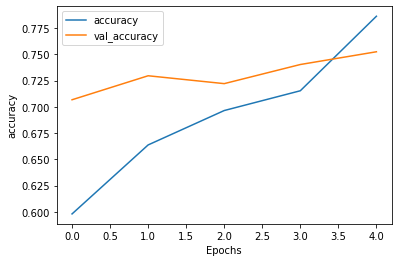

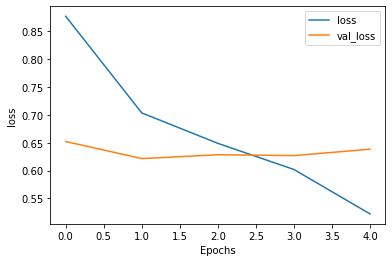

In [23]:
num_epochs = 5
fit_model_and_show_results(model_bidi_lstm, num_epochs, sample_seq)

#### Other techniques that can be used:
1. Using GRU & CNN and many other models 
2. State of the art pre-trained embeddings layer of text data 
    * Glove
    * Word2Vec
    * and many other pre-trained embeddings

3. Optimizing layers and nodes for improving the results


****************************************************************

### `Date Parsing`

#### Date parsing method using regex although we shoudn't use that

In [29]:
import re

# if separators should not be mixed use backreference:
date_reg_exp = re.compile("\d{4}[-/]\d{2}[-/]\d{2}")

# a string to test the regular expression above
test_str= """
     fsf2010/08/27sdfsdfsd
     dsf sfds f2010/08/26 fsdf 
     asdsds 2009-02-02 afdf
     """

# finds all the matches of the regular expression and
# returns a list containing them
matches_list = date_reg_exp.findall(test_str)

# iterates the matching list and prints all the matches
for match in matches_list:
    print (match)

2010/08/27
2010/08/26
2009-02-02


#### Another method

In [26]:
# using  datefinder library
import datefinder

string_with_dates = '''
    Central design committee session Tuesday 10/22 6:30 pm
    Th 9/19 LAB: Serial encoding (Section 2.2)
    There will be another one on December 15th for those who are unable to make it today.
    Workbook 3 (Minimum Wage): due Wednesday 9/18 11:59pm
    He will be flying in Sept. 15th.
    We expect to deliver this between late 2021 and early 2022.
'''

matches = datefinder.find_dates(string_with_dates)
for match in matches:
    print(match)

2020-10-22 18:30:00
2020-09-19 00:00:00
2020-05-02 00:00:00
2020-12-15 00:00:00
2020-05-03 00:00:00
2020-09-18 23:59:00
2020-09-15 00:00:00
2021-05-16 00:00:00
2022-05-16 00:00:00


# `************END **************`

*************************

#### Adding pre-trained text-embedding and using the model above and one more layer of LSTM(Bi-dir)

In [ ]:
# embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
# hub_layer = hub.KerasLayer(embedding, input_shape=[], 
#                            dtype=tf.string, trainable=True)

# EPOCHS = 10

# # Directory where the checkpoints will be saved
# checkpoint_dir = './training_checkpoints'
# # Name of the checkpoint files
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_prefix,
#     save_weights_only=True)


# METRICS = [
#       tf.keras.metrics.TruePositives(name='tp'),
#       tf.keras.metrics.FalsePositives(name='fp'),
#       tf.keras.metrics.TrueNegatives(name='tn'),
#       tf.keras.metrics.FalseNegatives(name='fn'), 
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),
#       tf.keras.metrics.AUC(name='auc'),
# ]

# # defining loss 
# def loss(labels, logits):
#       return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# model_fin= tf.keras.Sequential()
# model_fin.add(hub_layer)
# #model_fin_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,activation="relu", return_sequences=True)))
# model_fin.add(tf.keras.layers.Dropout(0.25, noise_shape=None, seed=None))

# model_fin.add(tf.keras.layers.Flatten())
# model_fin.add(tf.keras.layers.Dense(6, activation='relu'))
# model_fin.add(tf.keras.layers.Dense(3, activation='sigmoid'))

# model_fin.summary()

# # compiling model
# model_fin.compile(optimizer='adam',
#           loss=loss,
#           metrics=METRICS)

# model_fin.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
    

In [ ]:
#history = make_model(METRICS, checkpoint_callback, loss)